# 0.0 Import Libraries

In [ ]:
pip install spectral mat73  einops

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import sys
import os
import math
import pandas as pd

from einops import rearrange
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from scipy import io
import torch.utils.data
import scipy.io as sio
import mat73
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1.0 Upload Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! ls '/content/drive/MyDrive/A02_RemoteSensingData/UHS_2013_DFTC/'

2013_DFTC					 random_hsi_2013_data.mat
2013_IEEE_GRSS_DF_Contest_CASI_349_1905_144.mat  sorted_hsi_2013_data_least_to_most.mat
2013_IEEE_GRSS_DF_Contest_LiDAR.mat		 sorted_hsi_2013_data.mat
GRSS2013.mat					 TrainedModel
__MACOSX


In [ ]:
 # Define the path
path='/content/drive/MyDrive/A02_RemoteSensingData/UHS_2013_DFTC/'

In [ ]:
# 2.1 Loads Data
# Load hyperpsectral data
hsi_2013_data=sio.loadmat(path+'2013_IEEE_GRSS_DF_Contest_CASI_349_1905_144.mat')['ans']
print('hsi_2013_data shape:', hsi_2013_data.shape)

# Loader Lidar  data
import mat73
lidar_2013_data = sio.loadmat(path+'2013_IEEE_GRSS_DF_Contest_LiDAR.mat')['LiDAR_data']

print('Lidar_2013_data shape:', lidar_2013_data.shape)

#Load ground truth labels
gt_2013_data=sio.loadmat(path+'GRSS2013.mat')['name']
print('gt_2013_data.shape:', gt_2013_data.shape)

hsi_2013_data shape: (349, 1905, 144)
Lidar_2013_data shape: (349, 1905, 1)
gt_2013_data.shape: (349, 1905)


hsi_data shap: (349, 1905, 144)
lidar_data shap: (349, 1905, 1)
gt_data shap: (349, 1905)


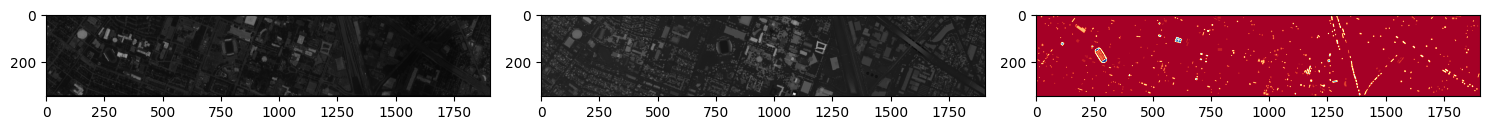

In [ ]:
import scipy.io
import matplotlib.pyplot as plt
import numpy as np

# path
hsi_data=hsi_2013_data
lidar_data=lidar_2013_data
gt_data=gt_2013_data
print('hsi_data shap:', hsi_data.shape)
print('lidar_data shap:', lidar_data.shape)
print('gt_data shap:', gt_data.shape)

# To plot image data, you can use matplotlib.pyplot's imshow function
# Here I'm showing the first band of the HSI data as an example. You may want to adjust this to suit your needs.

# To plot image data, you can use matplotlib.pyplot's imshow function
# Here I'm showing the first band of the HSI data as an example. You may want to adjust this to suit your needs.

plt.figure(figsize=(15,5))  # Adjust the figure size

plt.subplot(1,3,1)  # Change from 2,2,1 to 1,3,1
plt.imshow(hsi_data[:,:,10], cmap='gray')
#plt.title("HSI Data - First Band")

plt.subplot(1,3,2)  # Change from 2,2,3 to 1,3,2
plt.imshow(lidar_data[:,:,0], cmap='gist_gray')
#plt.title("LiDAR Data - First Band")

plt.subplot(1,3,3)  # Change from 2,2,4 to 1,3,3
plt.imshow(gt_data, cmap='RdYlBu')
#plt.title("Ground Truth")

plt.tight_layout()  # Use tight_layout to ensure that the subplots do not overlap
plt.show()

### 2.1  Samples Extraction

In [ ]:
# 2.1 Define the class information
class_info = [(1, "Healthy grass", 1251),
    (2, "Stressed grass", 1254),
    (3, "Synthetic grass", 697),
    (4, "Trees", 1244),
    (5, "Soil", 1242),
    (6, "Water", 325),
    (7, "Residential", 1268),
    (8, "Commercial", 1244),
    (9, "Road", 1252),
    (10, "Highway", 1227),
    (11, "Railway", 1235),
    (12, "Parking lot 1", 1233),
    (13, "Parking lot 2", 469),
    (14, "Tennis court", 428),
    (15, "Running track", 660)]

# Create a dictionary to store class number, class name, and class samples
class_dict = {class_number: {"class_name": class_name, "samples": samples} for class_number, class_name, samples in class_info}

print(class_dict)

{1: {'class_name': 'Healthy grass', 'samples': 1251}, 2: {'class_name': 'Stressed grass', 'samples': 1254}, 3: {'class_name': 'Synthetic grass', 'samples': 697}, 4: {'class_name': 'Trees', 'samples': 1244}, 5: {'class_name': 'Soil', 'samples': 1242}, 6: {'class_name': 'Water', 'samples': 325}, 7: {'class_name': 'Residential', 'samples': 1268}, 8: {'class_name': 'Commercial', 'samples': 1244}, 9: {'class_name': 'Road', 'samples': 1252}, 10: {'class_name': 'Highway', 'samples': 1227}, 11: {'class_name': 'Railway', 'samples': 1235}, 12: {'class_name': 'Parking lot 1', 'samples': 1233}, 13: {'class_name': 'Parking lot 2', 'samples': 469}, 14: {'class_name': 'Tennis court', 'samples': 428}, 15: {'class_name': 'Running track', 'samples': 660}}


In [ ]:
# 2.2 Samples Extraction

# # Create a mask with all class labels
# mask = np.copy(gt_2013_data)

# # Set the background class to 0
# mask[mask == 0] = 0

# Define patch size and stride
patch_size = 9
stride = 1

# Create an empty list to store patches and labels
hsi_samples = []
lidar_samples = []
labels = []

# Initialize a dictionary to store class count
class_count = {i: 0 for i in class_dict.keys()}

# Function to check if all classes have the required number of samples
def all_classes_completed(class_count, class_dict):
    return all(class_count[class_num] == class_dict[class_num]["samples"] for class_num in class_dict.keys())

while not all_classes_completed(class_count, class_dict):
    # Loop through the ground truth data
    for label in class_dict.keys():
        # Get the coordinates of the ground truth pixels
        #coords = np.argwhere((gt_2013_data == label) & (mask > 0))
        coords = np.argwhere(gt_2013_data == label)

        # Shuffle the coordinates to randomize the patch extraction
        np.random.shuffle(coords)

        for coord in coords:
            i, j = coord
            # Calculate the patch indices
            i_start, i_end = i - patch_size // 2, i + patch_size // 2 + 1
            j_start, j_end = j - patch_size // 2, j + patch_size // 2 + 1

            # Check if the indices are within the bounds of the HSI data
            if i_start >= 0 and i_end <= hsi_2013_data.shape[0] and j_start >= 0 and j_end <= hsi_2013_data.shape[1]:
                # Extract the patch
                hsi_patch = hsi_2013_data[i_start:i_end, j_start:j_end, :]

                # Extract the LiDAR patch
                lidar_patch = lidar_2013_data[i_start:i_end, j_start:j_end, :]

                # If the class count is less than the required samples
                if class_count[label] < class_dict[label]["samples"]:
                    # Append the patch and its label to the list
                    hsi_samples.append(hsi_patch)
                    lidar_samples.append(lidar_patch)
                    labels.append(label)
                    class_count[label] += 1

                    # If all classes have the required number of samples, exit the loop
                    if all_classes_completed(class_count, class_dict):
                        break

# Convert the list of patches and labels into arrays
hsi_samples = np.array(hsi_samples)
lidar_samples = np.array(lidar_samples)
labels = np.array(labels)
print('hsi_samples shape:', hsi_samples.shape)
print('lidar_samples shape:', lidar_samples.shape)
print('labels shape:', labels.shape)

hsi_samples shape: (15029, 9, 9, 144)
lidar_samples shape: (15029, 9, 9, 1)
labels shape: (15029,)


### 2.2 Training samples extraction

In [ ]:
# 2.5 Training samples extraction
# The desired number of samples for each class
training_samples = [198, 190, 192, 188, 186, 182, 196, 191, 193, 191, 181, 192, 184, 181, 187]
#training_samples = [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
training_samples_dict = {i+1: size for i, size in enumerate(training_samples)}

# Initialize a dictionary to store class count
class_count = {i: 0 for i in class_dict.keys()}

# Function to check if all classes have the required number of samples
def all_classes_completed(class_count, training_samples_dict):
    return all(class_count[class_num] == training_samples_dict[class_num] for class_num in class_dict.keys())

# Create an empty list to store patches and labels
training_hsi_samples = []
training_lidar_samples = []
training_labels = []

while not all_classes_completed(class_count, training_samples_dict):
    # Loop through the ground truth data
    for label in class_dict.keys():
        # Get the coordinates of the ground truth pixels
        coords = np.argwhere(gt_2013_data == label)

        # Shuffle the coordinates to randomize the patch extraction
        np.random.shuffle(coords)

        for coord in coords:
            i, j = coord
            # Calculate the patch indices
            i_start, i_end = i - patch_size // 2, i + patch_size // 2 + 1
            j_start, j_end = j - patch_size // 2, j + patch_size // 2 + 1

            # Check if the indices are within the bounds of the HSI data
            if i_start >= 0 and i_end <= hsi_2013_data.shape[0] and j_start >= 0 and j_end <= hsi_2013_data.shape[1]:
                # Extract the patch
                hsi_patch = hsi_2013_data[i_start:i_end, j_start:j_end, :]

                # Extract the LiDAR patch
                lidar_patch = lidar_2013_data[i_start:i_end, j_start:j_end, :]

                # If the class count is less than the required samples
                if class_count[label] < training_samples_dict[label]:
                    # Append the patch and its label to the list
                    training_hsi_samples.append(hsi_patch)
                    training_lidar_samples.append(lidar_patch)
                    training_labels.append(label)
                    class_count[label] += 1

                    # If all classes have the required number of samples, exit the loop
                    if all_classes_completed(class_count, training_samples_dict):
                        break

training_hsi_samples = np.array(training_hsi_samples)
training_lidar_samples = np.array(training_lidar_samples)
training_labels = np.array(training_labels)
print('training_hsi_samples shape:', training_hsi_samples.shape)
print('training_lidar_samples shape:', training_lidar_samples.shape)
print('training_labels shape:', training_labels.shape)

training_hsi_samples shape: (150, 9, 9, 144)
training_lidar_samples shape: (150, 9, 9, 1)
training_labels shape: (150,)


In [ ]:
# Assuming `hsi_samples`, `lidar_samples`, and `labels` have been previously defined

# Convert the list of patches and labels into arrays if they aren't already
hsi_samples = np.array(hsi_samples)
lidar_samples = np.array(lidar_samples)
labels = np.array(labels)

# Create lists to store training and test samples and labels
hsi_training_samples, lidar_training_samples, training_labels = [], [], []
hsi_test_samples, lidar_test_samples, test_labels = [], [], []

# Split samples into training and test sets based on the desired number of training samples
for label, train_samples in training_samples_dict.items():
    # Get indices of the current class
    class_indices = np.where(labels == label)[0]

    # Randomly shuffle the indices
    np.random.shuffle(class_indices)

    # Split the indices into training and test set indices
    train_indices = class_indices[:train_samples]
    test_indices = class_indices[train_samples:]

    # Add training samples and labels for the current class
    hsi_training_samples.extend(hsi_samples[train_indices])
    lidar_training_samples.extend(lidar_samples[train_indices])
    training_labels.extend(labels[train_indices])

    # Add test samples and labels for the current class
    hsi_test_samples.extend(hsi_samples[test_indices])
    lidar_test_samples.extend(lidar_samples[test_indices])
    test_labels.extend(labels[test_indices])

# Convert lists back to numpy arrays
hsi_training_samples = np.array(hsi_training_samples)
lidar_training_samples = np.array(lidar_training_samples)
training_labels = np.array(training_labels)

hsi_test_samples = np.array(hsi_test_samples)
lidar_test_samples = np.array(lidar_test_samples)
test_labels = np.array(test_labels)

# Print shapes to verify
print('hsi_training_samples shape:', hsi_training_samples.shape)
print('lidar_training_samples shape:', lidar_training_samples.shape)
print('training_labels shape:', training_labels.shape)

print('hsi_test_samples shape:', hsi_test_samples.shape)
print('lidar_test_samples shape:', lidar_test_samples.shape)
print('test_labels shape:', test_labels.shape)


hsi_training_samples shape: (150, 9, 9, 144)
lidar_training_samples shape: (150, 9, 9, 1)
training_labels shape: (150,)
hsi_test_samples shape: (14879, 9, 9, 144)
lidar_test_samples shape: (14879, 9, 9, 1)
test_labels shape: (14879,)


In [ ]:
# p=9, n=50000, adm, lr=0.0001
top_1_seed42=  [107]
top_5_seed42= [73, 117, 107, 89, 34]
top_10_seed42= [85, 10, 137, 107, 34, 59, 47, 140, 117, 108]
top_15_seed42=[94, 119, 107, 17, 57, 117, 59, 47, 3, 34, 10, 140, 85, 58, 137]
top_20_seed42=[3, 5, 17, 33, 85, 59, 117, 140, 94, 57, 108, 71, 41, 136, 107, 34, 58, 24, 51, 123]
top_25_seed42= [10, 117, 30, 140, 107, 34, 15, 85, 41, 119, 95, 35, 96, 137, 58, 1, 60, 136, 108, 143, 57, 59, 5, 123, 3]
top_30_seed42= [1, 108, 141, 51, 95, 49, 60, 47, 80, 10, 132, 12, 119, 137, 106, 15, 41, 34, 3, 107, 57, 58, 136, 140, 59, 5, 131, 94, 85, 117]
top_35_seed42= [10, 129, 30, 140, 107, 34, 15, 85, 41, 119, 95, 13, 51, 137, 58, 1, 60, 136, 108, 143, 31, 59, 141, 123, 3, 131, 57, 47, 132, 70, 2, 49, 5, 117, 124]
top_40_seed42= [10, 129, 30, 140, 107, 34, 15, 85, 56, 119, 42, 13, 51, 137, 58, 1, 60, 136, 108, 143, 12, 59, 141, 123, 3, 131, 57, 47, 132, 70, 2, 49, 5, 117, 124, 31, 77, 95, 22, 41]
top_45_seed42=[123, 129, 3, 141, 34, 30, 70, 2, 59, 26, 85, 17, 77, 108, 137, 47, 95, 107, 31, 58, 51, 57, 36, 13, 10, 136, 12, 131, 143, 60, 124, 5, 140, 1, 117, 132, 119, 91, 41, 49, 42, 135, 22, 74, 9]

top_50_seed42= [113, 141, 95, 34, 46, 85, 129, 74, 137, 63, 83, 26, 107, 106, 12, 1, 13, 51, 58, 108, 10, 70, 136, 57, 91, 36, 60, 5, 143, 30, 131, 117, 41, 140, 59, 115, 27, 47, 119, 31, 3, 130, 17, 42, 132, 49, 2, 142, 124, 54]

In [ ]:
# Jul. 23, 2024 SGD band selecteion Patch 9 vbased on samples=30000
top_1_seed42=  [125]
top_5_seed42=  [125, 75, 61, 9, 133]
top_10_seed42=  [136, 75, 61, 133, 87, 27, 13, 9, 125, 56]
top_15_seed42=  [27, 8, 125, 133, 61, 136, 13, 48, 87, 85, 56, 75, 9, 58, 55]
top_20_seed42=  [85, 8, 61, 133, 65, 13, 9, 58, 56, 75, 136, 27, 87, 52, 48, 55, 125, 82, 106, 66]
top_25_seed42=  [106, 8, 61, 133, 56, 13, 58, 9, 0, 75, 27, 82, 55, 136, 125, 87, 65, 48, 143, 66, 76, 85, 140, 52, 71]
top_30_seed42=  [142, 8, 76, 133, 87, 62, 71, 48, 52, 56, 75, 143, 85, 136, 82, 55, 65, 9, 61, 20, 58, 13, 128, 66, 28, 0, 106, 125, 57, 27]
top_35_seed42= [52, 8, 76, 133, 48, 115, 13, 142, 87, 85, 62, 75, 72, 58, 55, 82, 65, 105, 61, 136, 9, 125, 3, 27, 70, 28, 71, 26, 20, 0, 66, 56, 106, 86, 57]
top_40_seed42=  [52, 75, 61, 133, 56, 9, 71, 143, 142, 8, 62, 28, 20, 85, 55, 65, 72, 136, 87, 11, 76, 13, 0, 105, 109, 27, 26, 57, 125, 115, 70, 66, 82, 128, 92, 118, 3, 58, 106, 48]
top_45_seed42=  [52, 8, 26, 133, 109, 115, 7, 58, 142, 55, 62, 75, 11, 66, 83, 92, 57, 65, 0, 105, 20, 76, 71, 27, 61, 116, 48, 87, 3, 136, 56, 28, 53, 85, 9, 34, 125, 82, 13, 72, 70, 106, 140, 54, 93]
top_50_seed42=  [142, 8, 26, 71, 133, 115, 118, 9, 92, 75, 62, 82, 128, 93, 34, 55, 20, 65, 13, 53, 57, 70, 124, 76, 0, 66, 109, 11, 87, 27, 131, 61, 54, 125, 116, 56, 58, 28, 106, 48, 83, 136, 52, 140, 7, 3, 105, 60, 143, 85]
top_55_seed42=  [53, 8, 26, 133, 14, 71, 56, 57, 87, 75, 62, 54, 72, 124, 65, 55, 11, 9, 136, 128, 13, 3, 118, 143, 59, 27, 76, 142, 28, 48, 34, 61, 125, 82, 115, 105, 70, 0, 93, 116, 7, 83, 52, 43, 66, 92, 58, 139, 46, 130, 106, 20, 109, 85, 111]
top_60_seed42=  [46, 8, 26, 133, 62, 139, 66, 71, 65, 118, 82, 75, 48, 84, 115, 55, 28, 69, 87, 9, 54, 13, 57, 76, 27, 143, 124, 72, 61, 85, 56, 20, 109, 125, 116, 136, 11, 0, 140, 51, 128, 58, 92, 43, 131, 3, 7, 129, 14, 138, 70, 142, 106, 52, 93, 83, 39, 22, 105, 53]
top_65_seed42=  [55, 105, 8, 61, 133, 27, 70, 9, 13, 60, 65, 75, 82, 57, 131, 115, 143, 66, 20, 28, 76, 71, 125, 84, 62, 87, 56, 54, 48, 74, 106, 26, 52, 72, 11, 128, 69, 109, 14, 7, 138, 140, 142, 116, 139, 83, 136, 0, 92, 93, 3, 85, 43, 58, 5, 22, 118, 129, 31, 111, 130, 64, 124, 46, 4]
top_70_seed42= [16, 8, 61, 53, 133, 56, 55, 31, 140, 71, 75, 54, 62, 72, 105, 82, 65, 76, 130, 143, 13, 52, 136, 9, 14, 27, 17, 106, 115, 66, 139, 114, 11, 26, 48, 60, 46, 28, 7, 116, 57, 3, 124, 87, 5, 4, 83, 129, 70, 43, 109, 128, 125, 85, 39, 34, 0, 142, 93, 69, 138, 20, 123, 51, 92, 58, 131, 59, 41, 42]
top_75_seed42=  [28, 8, 9, 61, 133, 125, 115, 71, 142, 3, 33, 75, 66, 20, 118, 55, 11, 76, 128, 65, 92, 124, 136, 13, 16, 0, 139, 140, 27, 56, 143, 82, 26, 5, 87, 7, 72, 131, 52, 14, 70, 138, 83, 34, 64, 60, 59, 105, 93, 97, 58, 122, 43, 84, 109, 130, 54, 119, 116, 57, 111, 53, 31, 106, 129, 4, 41, 39, 85, 46, 17, 48, 45, 134, 62]
top_80_seed42=  [19, 8, 65, 52, 133, 26, 129, 142, 62, 87, 75, 58, 111, 11, 56, 136, 55, 48, 5, 13, 72, 76, 125, 105, 3, 28, 27, 57, 14, 70, 61, 130, 115, 66, 82, 118, 106, 12, 9, 17, 116, 138, 109, 140, 93, 7, 44, 24, 69, 60, 54, 83, 139, 16, 0, 84, 43, 51, 85, 100, 31, 71, 123, 124, 53, 20, 22, 39, 92, 131, 59, 126, 119, 117, 143, 33, 128, 74, 4, 41]
top_85_seed42=  [13, 75, 84, 76, 133, 27, 70, 51, 16, 65, 8, 72, 55, 143, 131, 11, 56, 61, 71, 110, 126, 17, 116, 54, 62, 69, 48, 115, 118, 105, 57, 41, 87, 34, 26, 82, 5, 3, 130, 139, 28, 106, 20, 93, 9, 136, 7, 67, 58, 125, 83, 128, 85, 43, 129, 142, 109, 52, 141, 53, 111, 64, 138, 0, 46, 10, 103, 60, 86, 92, 74, 14, 4, 66, 33, 124, 113, 39, 140, 63, 134, 59, 31, 12, 42]
top_90_seed42=  [8, 140, 61, 133, 70, 56, 125, 71, 48, 75, 62, 3, 117, 82, 138, 55, 65, 87, 76, 66, 60, 106, 131, 58, 7, 27, 28, 24, 136, 59, 14, 115, 114, 11, 9, 139, 130, 17, 72, 46, 26, 54, 143, 53, 5, 69, 74, 4, 110, 93, 42, 142, 43, 97, 128, 123, 129, 13, 109, 111, 85, 113, 34, 57, 20, 0, 122, 118, 92, 51, 83, 39, 33, 41, 134, 94, 124, 103, 116, 31, 16, 119, 12, 64, 22, 141, 38, 40, 105, 52]
top_95_seed42=  [72, 8, 26, 133, 118, 27, 7, 142, 70, 115, 20, 75, 125, 55, 11, 123, 58, 17, 54, 65, 9, 76, 128, 62, 56, 71, 67, 105, 22, 122, 61, 87, 131, 109, 82, 116, 124, 28, 139, 0, 42, 143, 113, 34, 43, 53, 5, 13, 93, 129, 64, 84, 41, 24, 100, 63, 138, 106, 46, 69, 83, 92, 85, 14, 119, 97, 111, 48, 130, 33, 51, 74, 39, 141, 103, 31, 134, 66, 117, 4, 79, 2, 52, 59, 110, 3, 57, 12, 136, 80, 10, 60, 16, 140, 19]
top_100_seed42= [87, 8, 19, 26, 133, 104, 115, 71, 84, 62, 11, 3, 75, 55, 34, 5, 14, 65, 124, 51, 4, 27, 128, 13, 76, 63, 28, 56, 72, 48, 123, 79, 61, 70, 82, 117, 138, 16, 17, 118, 43, 141, 7, 140, 58, 54, 131, 109, 24, 53, 129, 142, 93, 139, 111, 6, 106, 60, 9, 125, 85, 46, 64, 20, 39, 31, 0, 44, 97, 91, 59, 57, 126, 119, 41, 92, 110, 33, 113, 30, 98, 130, 74, 38, 103, 83, 143, 94, 134, 105, 12, 116, 22, 2, 136, 52, 69, 67, 10, 66]
top_105_seed42=  [122, 8, 61, 24, 133, 115, 7, 91, 4, 33, 75, 55, 111, 10, 92, 11, 65, 76, 106, 5, 71, 22, 9, 113, 41, 27, 131, 26, 69, 142, 56, 31, 74, 138, 28, 53, 82, 46, 45, 13, 44, 109, 70, 42, 54, 85, 128, 14, 80, 93, 130, 72, 123, 34, 129, 118, 125, 43, 139, 103, 124, 51, 97, 63, 84, 20, 39, 17, 119, 58, 38, 0, 126, 83, 59, 12, 48, 64, 110, 98, 134, 79, 19, 52, 3, 62, 87, 16, 60, 94, 105, 140, 107, 143, 100, 141, 2, 114, 117, 66, 57, 104, 136, 116, 67]
top_110_seed42=  [12, 8, 26, 133, 62, 139, 34, 71, 65, 118, 82, 75, 48, 142, 115, 55, 28, 97, 80, 9, 54, 13, 63, 76, 27, 143, 126, 72, 61, 130, 56, 20, 109, 125, 45, 123, 11, 36, 67, 51, 128, 58, 17, 43, 131, 120, 7, 129, 41, 138, 70, 114, 64, 98, 93, 83, 39, 110, 94, 53, 92, 85, 103, 44, 31, 42, 111, 74, 33, 105, 4, 10, 141, 59, 106, 22, 5, 87, 79, 119, 14, 52, 91, 16, 0, 19, 134, 60, 100, 116, 38, 117, 46, 69, 136, 3, 122, 104, 66, 24, 124, 2, 84, 57, 140, 113, 107, 108, 40, 77]
top_115_seed42= [141, 8, 26, 9, 133, 115, 94, 71, 33, 97, 75, 82, 100, 136, 55, 42, 48, 65, 84, 66, 51, 13, 76, 128, 54, 140, 72, 61, 27, 70, 28, 41, 11, 56, 109, 88, 43, 138, 30, 103, 17, 7, 45, 125, 113, 57, 2, 98, 111, 142, 83, 139, 22, 143, 36, 20, 53, 129, 64, 85, 119, 92, 130, 134, 4, 126, 14, 39, 62, 93, 69, 46, 59, 0, 87, 58, 74, 91, 31, 5, 24, 10, 63, 16, 6, 60, 52, 123, 110, 118, 12, 105, 3, 44, 19, 122, 38, 80, 79, 114, 124, 104, 106, 67, 131, 116, 117, 86, 107, 40, 108, 81, 68, 34, 120]
top_120_seed42=  [138, 8, 26, 133, 33, 7, 122, 2, 115, 34, 75, 92, 98, 55, 11, 123, 125, 9, 18, 65, 76, 60, 139, 41, 130, 38, 129, 27, 12, 67, 56, 54, 72, 28, 103, 61, 82, 100, 109, 117, 126, 43, 13, 44, 20, 70, 36, 84, 39, 53, 97, 93, 64, 128, 62, 57, 110, 94, 131, 108, 104, 71, 85, 66, 14, 4, 51, 83, 52, 17, 119, 113, 58, 30, 111, 59, 31, 69, 0, 45, 63, 79, 6, 74, 16, 124, 134, 42, 141, 80, 22, 10, 5, 87, 143, 107, 106, 105, 32, 40, 3, 86, 91, 46, 120, 140, 116, 121, 136, 68, 118, 102, 24, 142, 81, 48, 135, 90, 19, 114]
top_125_seed42= [43, 8, 61, 133, 17, 56, 9, 71, 5, 75, 11, 27, 83, 68, 55, 58, 65, 76, 34, 20, 51, 62, 112, 126, 13, 121, 100, 16, 79, 2, 72, 26, 128, 115, 70, 28, 82, 123, 42, 139, 105, 48, 116, 53, 7, 32, 54, 14, 119, 0, 30, 143, 135, 93, 73, 138, 125, 111, 85, 102, 52, 6, 110, 41, 39, 92, 141, 74, 103, 129, 88, 98, 142, 60, 4, 120, 59, 64, 134, 80, 10, 87, 31, 38, 117, 97, 22, 33, 94, 36, 44, 114, 122, 107, 3, 124, 131, 69, 66, 104, 46, 57, 130, 136, 67, 113, 84, 45, 81, 24, 86, 108, 63, 12, 25, 40, 19, 91, 118, 18, 90, 106, 109, 89, 140]
top_130_seed42= [105, 8, 61, 133, 56, 17, 9, 71, 5, 75, 57, 33, 53, 82, 55, 141, 76, 65, 20, 121, 66, 13, 139, 32, 18, 27, 87, 48, 26, 115, 28, 113, 74, 11, 25, 4, 22, 89, 116, 7, 69, 16, 77, 135, 52, 14, 43, 58, 84, 125, 51, 129, 109, 3, 138, 70, 93, 127, 54, 88, 102, 80, 31, 39, 85, 97, 41, 111, 119, 81, 92, 136, 123, 63, 0, 62, 59, 24, 103, 94, 83, 44, 1, 38, 107, 117, 19, 131, 2, 100, 46, 79, 110, 34, 134, 143, 142, 104, 98, 45, 122, 10, 68, 124, 112, 140, 60, 6, 67, 72, 108, 120, 36, 12, 40, 91, 118, 42, 106, 23, 86, 126, 73, 130, 128, 114, 64, 30, 21, 101]
top_135_seed42=  [50, 8, 26, 133, 117, 27, 71, 30, 31, 115, 75, 14, 22, 39, 11, 55, 2, 65, 84, 102, 62, 13, 76, 19, 28, 98, 63, 61, 101, 4, 88, 113, 48, 78, 107, 92, 82, 72, 7, 56, 93, 1, 58, 67, 70, 43, 73, 83, 139, 138, 129, 9, 85, 128, 100, 111, 53, 47, 54, 97, 18, 124, 143, 116, 137, 81, 17, 0, 41, 119, 140, 141, 33, 110, 20, 103, 10, 59, 89, 6, 74, 16, 87, 134, 52, 68, 80, 38, 94, 106, 3, 57, 131, 105, 104, 136, 46, 135, 24, 45, 112, 122, 130, 44, 32, 66, 108, 34, 120, 79, 142, 12, 60, 77, 42, 69, 109, 40, 114, 36, 125, 91, 118, 86, 64, 126, 21, 51, 121, 5, 25, 123, 37, 127, 23]
top_140_seed42=  [87, 8, 65, 67, 133, 61, 39, 129, 20, 62, 75, 103, 116, 102, 115, 55, 36, 11, 7, 22, 76, 16, 120, 137, 118, 89, 17, 101, 18, 77, 82, 27, 56, 70, 78, 58, 26, 138, 48, 54, 96, 29, 143, 28, 139, 37, 71, 112, 41, 100, 13, 93, 106, 23, 68, 34, 109, 43, 66, 111, 97, 85, 119, 124, 42, 141, 104, 59, 14, 131, 83, 52, 92, 105, 4, 110, 117, 1, 33, 135, 74, 50, 80, 0, 47, 136, 107, 3, 38, 31, 60, 44, 2, 46, 134, 79, 84, 30, 57, 45, 125, 19, 140, 122, 113, 94, 10, 108, 88, 81, 24, 72, 69, 121, 63, 91, 6, 142, 40, 12, 90, 32, 114, 73, 86, 21, 126, 51, 64, 123, 25, 98, 127, 130, 5, 9, 53, 128, 132, 95]
top_144_seed42= [102, 8, 26, 133, 62, 139, 6, 71, 65, 118, 82, 75, 48, 112, 115, 55, 28, 97, 80, 29, 54, 13, 68, 76, 27, 143, 89, 49, 61, 121, 56, 20, 73, 125, 45, 78, 11, 36, 67, 51, 25, 58, 17, 43, 95, 120, 7, 129, 41, 35, 70, 18, 64, 98, 93, 83, 39, 110, 94, 90, 92, 85, 103, 44, 31, 81, 111, 74, 33, 105, 4, 10, 141, 59, 127, 22, 50, 87, 79, 119, 14, 52, 135, 16, 0, 19, 134, 60, 100, 116, 38, 117, 46, 69, 136, 3, 122, 104, 66, 24, 124, 2, 84, 57, 140, 113, 107, 108, 40, 77, 42, 32, 12, 142, 109, 106, 114, 47, 63, 91, 128, 34, 126, 88, 86, 21, 123, 101, 130, 1, 37, 30, 137, 5, 53, 23, 9, 96, 132, 99, 131, 72, 15, 138]

In [ ]:
# Generate a list of indices for the 144 bands
full_bands = list(range(144))

# Print the list of band indices
print("Band Indices:", full_bands)

Band Indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143]


# CNN Test Based On Selected Best Bands

In [ ]:
import matplotlib.pyplot as plt

import numpy as np
import seaborn as sns
from scipy.io import loadmat
import mat73

import pandas as pd

from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score,
                             confusion_matrix, classification_report)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

from tqdm import tqdm
from numpy.random import seed
from time import time
import time

seed(42)

##Augmente data

In [ ]:
import numpy as np
from scipy.ndimage import rotate

def augment_training_data(hsi_training_data, lidar_training_data, training_labels, rotations=[15, 45, 90, 120, 135], flip_up_down=True, flip_left_right=True):
    augmented_hsi = []
    augmented_lidar = []
    augmented_labels = []

    for hsi, lidar, label in zip(hsi_training_data, lidar_training_data, training_labels):
        # Original data
        augmented_hsi.append(hsi)
        augmented_lidar.append(lidar)
        augmented_labels.append(label)

        # Rotations
        for angle in rotations:
            hsi_rotated = rotate(hsi, angle, axes=(0, 1), reshape=False, mode='nearest')
            lidar_rotated = rotate(lidar, angle, axes=(0, 1), reshape=False, mode='nearest')

            augmented_hsi.append(hsi_rotated)
            augmented_lidar.append(lidar_rotated)
            augmented_labels.append(label)

        # Flip up-down
        if flip_up_down:
            hsi_flipped_ud = np.flipud(hsi)
            lidar_flipped_ud = np.flipud(lidar)

            augmented_hsi.append(hsi_flipped_ud)
            augmented_lidar.append(lidar_flipped_ud)
            augmented_labels.append(label)

        # Flip left-right
        if flip_left_right:
            hsi_flipped_lr = np.fliplr(hsi)
            lidar_flipped_lr = np.fliplr(lidar)

            augmented_hsi.append(hsi_flipped_lr)
            augmented_lidar.append(lidar_flipped_lr)
            augmented_labels.append(label)

    return np.array(augmented_hsi), np.array(augmented_lidar), np.array(augmented_labels)

# Augmenting the training samples
augmented_hsi_training_samples, augmented_lidar_training_samples, augmented_training_labels = augment_training_data(hsi_training_samples, lidar_training_samples, training_labels)

# Print shapes to verify the augmented training data
print('Augmented HSI training samples shape:', augmented_hsi_training_samples.shape)
print('Augmented LiDAR training samples shape:', augmented_lidar_training_samples.shape)
print('Augmented training labels shape:', augmented_training_labels.shape)

Augmented HSI training samples shape: (1200, 9, 9, 144)
Augmented LiDAR training samples shape: (1200, 9, 9, 1)
Augmented training labels shape: (1200,)


In [ ]:
augmented_hsi_train_samples=augmented_hsi_training_samples
augmented_lidar_train_samples=augmented_lidar_training_samples
augmented_train_labels=augmented_training_labels

hsi_test_samples=hsi_test_samples
lidar_test_samples=lidar_test_samples
test_labels=test_labels

# Print out
print('Augmented HSI training samples shape:', augmented_hsi_train_samples.shape)
print('Augmented LiDAR training samples shape:', augmented_lidar_train_samples.shape)
print('Augmented training labels shape:', augmented_train_labels.shape)

print('hsi_test_samples shape:', hsi_test_samples.shape)
print('lidar_test_samples shape:', lidar_test_samples.shape)
print('test_labels shape:', test_labels.shape)


Augmented HSI training samples shape: (1200, 9, 9, 144)
Augmented LiDAR training samples shape: (1200, 9, 9, 1)
Augmented training labels shape: (1200,)
hsi_test_samples shape: (14879, 9, 9, 144)
lidar_test_samples shape: (14879, 9, 9, 1)
test_labels shape: (14879,)


In [ ]:
# USing Augmentation training sample to test
# Define the band indices you're interested in
#band_indices = bands_aug[:1]
#band_indices = bands_aug1[:50]
#band_indices = bands_p9[:50]
#band_indices=bands_lrr[:1]
#band_indices=bands_asps[:35]
#band_indices=bands_opbs[:1]
#band_indices=bands_trc[:1]
#band_indices=bands_bsnet[:1]
#band_indices=bands_rlffc[:50]
#band_indices = np.arange(144)
band_indices=top_75_seed42

# # Extract the corresponding bands from the HSI samples
# selected_hsi_samples = augmented_hsi_samples[:,:,:, band_indices]
# selected_lidar_samples = augmented_lidar_samples
# label=augmented_labels
selected_training_lables=augmented_train_labels
selected_test_labels=test_labels
# print('selected_hsi_samples shape:', selected_hsi_samples.shape)
# print('selected_lidar_samples shape:', selected_lidar_samples.shape)
# print('label shape:', label.shape)
print('selected_training_lables shape:', selected_training_lables.shape)
print('selected_test_labels shape:', selected_test_labels.shape)

selected_hsi_train_samples = augmented_hsi_train_samples[:,:,:, band_indices]
selected_hsi_test_samples = hsi_test_samples[:,:,:, band_indices]
selected_lidar_train =  augmented_lidar_train_samples
selected_lidar_test = lidar_test_samples
print('selected_hsi_train_samples  shape:', selected_hsi_train_samples .shape)
print('selected_hsi_test_sample shape:', selected_hsi_test_samples.shape)
print('selected_lidar_train shape:', selected_lidar_train.shape)
print('selected_lidar_test shape:', selected_lidar_test.shape)

# #Adding LiDAR Data to Reduced bands HSI Data
# # Concatenate the data
# Concatenate the data along axis 3
#selected_hsi_lidar_samples = np.concatenate([selected_hsi_samples, selected_lidar_samples], axis=3)
selected_hsi_lidar_train_samples  = np.concatenate([selected_hsi_train_samples, selected_lidar_train], axis=3)
selected_hsi_lidar_test_samples  = np.concatenate([selected_hsi_test_samples, selected_lidar_test], axis=3)

# print('selected_hsi_lidar_samples shape:', selected_hsi_lidar_samples.shape)
# print('selected_lidar_samples shape:', selected_lidar_samples.shape)
# print('selected_hsi_lidar_samples shape:', selected_hsi_lidar_samples.shape)
print('selected_hsi_lidar_train_samples shape:', selected_hsi_lidar_train_samples.shape)
print('selected_hsi_lidar_test_samples shape:', selected_hsi_lidar_test_samples.shape)

# # Concatenate the data
#selected_hsi_lidar_samples  = np.concatenate([selected_hsi_samples, selected_lidar_samples], axis=3)
selected_hsi_lidar_train_samples  = np.concatenate([selected_hsi_train_samples, selected_lidar_train], axis=3)
selected_hsi_lidar_test_samples  = np.concatenate([selected_hsi_test_samples, selected_lidar_test], axis=3)

# print('selected_hsi_samples shape:', selected_hsi_samples.shape)
# print('selected_lidar_samples shape:', selected_lidar_samples.shape)
#print('selected_hsi_lidar_samples shape:', selected_hsi_lidar_samples.shape)
print('selected_hsi_lidar_train_samples shape:', selected_hsi_lidar_train_samples.shape)
print('selected_hsi_lidar_test_samples shape:', selected_hsi_lidar_test_samples.shape)

X_train=selected_hsi_lidar_train_samples
X_test=selected_hsi_lidar_test_samples
y_train=augmented_training_labels
y_test=test_labels

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

selected_training_lables shape: (1200,)
selected_test_labels shape: (14879,)
selected_hsi_train_samples  shape: (1200, 9, 9, 75)
selected_hsi_test_sample shape: (14879, 9, 9, 75)
selected_lidar_train shape: (1200, 9, 9, 1)
selected_lidar_test shape: (14879, 9, 9, 1)
selected_hsi_lidar_train_samples shape: (1200, 9, 9, 76)
selected_hsi_lidar_test_samples shape: (14879, 9, 9, 76)
selected_hsi_lidar_train_samples shape: (1200, 9, 9, 76)
selected_hsi_lidar_test_samples shape: (14879, 9, 9, 76)
X_train shape: (1200, 9, 9, 76)
X_test shape: (14879, 9, 9, 76)
y_train shape: (1200,)
y_test shape: (14879,)


# Preprae Data for 3DCNN

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, TensorDataset

# Then, split the training + validation set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.10, random_state=42, stratify=y_train)  # 0.25 * 0.8 = 0.2

# Convert the data to the required shape: [batch_size, in_channels, depth, height, width]
X_train = np.transpose(X_train, (0, 3, 1, 2))  # shape: (9618, 144, 7, 7)
X_val = np.transpose(X_val, (0, 3, 1, 2))  # shape: (2405, 144, 7, 7)
X_test = np.transpose(X_test, (0, 3, 1, 2))  # shape: (3006, 144, 7, 7)
print('X_train shape:', X_train.shape)
print('X_val shape:', X_val.shape)
print('X_test shape:', X_test.shape)

# Add a single channel depth dimension for compatibility with 3D convolutions
X_train = X_train[:, :, :, :, np.newaxis]
X_val = X_val[:, :, :, :, np.newaxis]
X_test = X_test[:, :, :, :, np.newaxis]

# Convert the splits into PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


X_train shape: (1080, 76, 9, 9)
X_val shape: (120, 76, 9, 9)
X_test shape: (14879, 76, 9, 9)


# Update the model using ResdulaBlock

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class ResidualBlock3D(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock3D, self).__init__()
        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm3d(out_channels)
        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm3d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv3d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm3d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class Simple3DCNN(nn.Module):
    def __init__(self, num_classes):
        super(Simple3DCNN, self).__init__()
        self.layer1 = ResidualBlock3D(76, 32) # Change the channle number based on acutal applicaiton
        self.layer2 = ResidualBlock3D(32, 64)
        self.layer3 = ResidualBlock3D(64, 128)
        self.fc1 = nn.Linear(128 * 2 * 2 * 2, 512)  # Adjust based on final size after convolutions and pooling
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.layer1(x)
        x = F.max_pool3d(x, (2, 2, 1))  # Pooling that doesn't reduce the depth dimension

        x = self.layer2(x)
        x = F.max_pool3d(x, (2, 2, 1))  # Pooling that doesn't reduce the depth dimension

        x = self.layer3(x)
        x = F.adaptive_max_pool3d(x, (2, 2, 2))  # Adaptive pooling to ensure fixed output size

        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# Training the model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Early stopping class
class EarlyStopping:
    def __init__(self, patience=30, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_model = None

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(model)
        elif score < self.best_score:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(model)
            self.counter = 0

    def save_checkpoint(self, model):
        self.best_model = model.state_dict()

# Function to choose the optimizer
def get_optimizer(optimizer_name, model_parameters, lr=0.00001, weight_decay=1e-4):
    if optimizer_name == 'Adam':
        return optim.Adam(model_parameters, lr=lr, weight_decay=weight_decay)
    elif optimizer_name == 'SGD':
        return optim.SGD(model_parameters, lr=lr, weight_decay=weight_decay, momentum=0.8)
    elif optimizer_name == 'RMSprop':
        return optim.RMSprop(model_parameters, lr=lr, weight_decay=weight_decay, momentum=0.8)
    elif optimizer_name == 'Adagrad':
        return optim.Adagrad(model_parameters, lr=lr, weight_decay=weight_decay)
    else:
        raise ValueError(f"Optimizer {optimizer_name} not recognized. Please choose from 'Adam', 'SGD', 'RMSprop', or 'Adagrad'.")

# Training function with early stopping
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, patience):
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    best_val_acc = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels - 1
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)

        model.eval()
        val_loss = 0.0
        val_corrects = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                labels = labels - 1
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_corrects += torch.sum(preds == labels.data)

        val_loss = val_loss / len(val_loader.dataset)
        val_acc = val_corrects.double() / len(val_loader.dataset)

        print(f'Epoch {epoch}/{num_epochs - 1}')
        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        print(f'Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}')

        scheduler.step(val_loss)
        early_stopping(val_loss, model)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_wts = model.state_dict()

        if early_stopping.early_stop:
            print("Early stopping")
            break

    print('Best val Acc: {:4f}'.format(best_val_acc))
    model.load_state_dict(early_stopping.best_model)
    return model

# Define the model with residual blocks
num_classes = 15

# Assuming you have already defined train_loader, val_loader, and test_loader
num_epochs = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Simple3DCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()

# Choose the optimizer
optimizer_name = 'Adam'  # Change this to 'SGD', 'RMSprop', or 'Adagrad' to use different optimizers
#optimizer = get_optimizer(optimizer_name, model.parameters(), lr=0.00001, weight_decay=1e-4)
optimizer = get_optimizer(optimizer_name, model.parameters(), lr=0.00001)
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=30, verbose=True)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=30)

# Train the model with early stopping
model = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, patience=30)

# Save the trained model
model_save_path = 'best_model.pth'
torch.save(model.state_dict(), model_save_path)

# Load the model for evaluation
model.load_state_dict(torch.load(model_save_path))


Epoch 0/99
Train Loss: 2.6601 Acc: 0.1213
Val Loss: 2.6375 Acc: 0.1667
Epoch 1/99
Train Loss: 2.5329 Acc: 0.2907
Val Loss: 2.3931 Acc: 0.3667
Epoch 2/99
Train Loss: 2.4000 Acc: 0.4343
Val Loss: 2.2419 Acc: 0.5417
Epoch 3/99
Train Loss: 2.2581 Acc: 0.5037
Val Loss: 2.0614 Acc: 0.6333
Epoch 4/99
Train Loss: 2.0976 Acc: 0.5917
Val Loss: 1.8458 Acc: 0.6917
Epoch 5/99
Train Loss: 1.9184 Acc: 0.6083
Val Loss: 1.6804 Acc: 0.7667
Epoch 6/99
Train Loss: 1.7396 Acc: 0.6417
Val Loss: 1.4676 Acc: 0.8000
Epoch 7/99
Train Loss: 1.5614 Acc: 0.6806
Val Loss: 1.2972 Acc: 0.8333
Epoch 8/99
Train Loss: 1.4019 Acc: 0.6991
Val Loss: 1.1416 Acc: 0.8583
Epoch 9/99
Train Loss: 1.2397 Acc: 0.7343
Val Loss: 0.9789 Acc: 0.8417
Epoch 10/99
Train Loss: 1.1058 Acc: 0.7565
Val Loss: 0.8699 Acc: 0.8417
Epoch 11/99
Train Loss: 0.9832 Acc: 0.7787
Val Loss: 0.7764 Acc: 0.8833
Epoch 12/99
Train Loss: 0.8809 Acc: 0.8019
Val Loss: 0.6543 Acc: 0.8750
Epoch 13/99
Train Loss: 0.7952 Acc: 0.8176
Val Loss: 0.5757 Acc: 0.8750
Ep

<All keys matched successfully>

# Using Test loader to predict the model prediction accuracy

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, cohen_kappa_score

# Evaluate the model using the test data loader
def evaluate_model(model, test_loader, device):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            labels = labels - 1
            outputs = model(data)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_test_loss = test_loss / len(test_loader)
    overall_accuracy = accuracy_score(all_labels, all_preds)

    # Calculate Average Accuracy
    confusion = confusion_matrix(all_labels, all_preds)
    per_class_accuracy = np.diag(confusion) / np.sum(confusion, axis=1)
    average_accuracy = np.mean(per_class_accuracy)

    # Calculate Kappa coefficient
    kappa = cohen_kappa_score(all_labels, all_preds)

    # Detailed classification report
    report = classification_report(all_labels, all_preds, target_names=[str(i) for i in range(num_classes)])

    return avg_test_loss, overall_accuracy, average_accuracy, kappa, report, confusion

# Assuming you have already defined test_loader
test_loss, overall_accuracy, average_accuracy, kappa, classification_report, confusion_matrix = evaluate_model(model, test_loader, device)

#print(f'Test Loss: {test_loss:.4f}')
print(f'Overall Accuracy (OA): {overall_accuracy:.4f}')
print(f'Average Accuracy (AA): {average_accuracy:.4f}')
print(f'Kappa: {kappa:.4f}')
#print('Classification Report:')
#print(classification_report)
#print('Confusion Matrix:')
#print(confusion_matrix)
# Class-wise accuracies
class_accuracies = confusion_matrix.diagonal() / confusion_matrix.sum(axis=1)
for i, acc in enumerate(class_accuracies):
    print(f'Class {i + 1}: {acc * 100:.2f}%')


Overall Accuracy (OA): 0.8608
Average Accuracy (AA): 0.8761
Kappa: 0.8495
Class 1: 96.86%
Class 2: 95.42%
Class 3: 99.56%
Class 4: 97.65%
Class 5: 99.84%
Class 6: 80.00%
Class 7: 87.20%
Class 8: 63.13%
Class 9: 88.24%
Class 10: 62.45%
Class 11: 71.43%
Class 12: 76.04%
Class 13: 98.69%
Class 14: 97.61%
Class 15: 100.00%


In [ ]:
# bands=75


In [ ]:
# bands=80
Overall Accuracy (OA): 0.8742
Average Accuracy (AA): 0.8894
Kappa: 0.8640
Class 1: 96.62%
Class 2: 96.62%
Class 3: 99.85%
Class 4: 99.27%
Class 5: 99.76%
Class 6: 84.76%
Class 7: 90.70%
Class 8: 55.59%
Class 9: 83.82%
Class 10: 82.74%
Class 11: 65.88%
Class 12: 82.42%
Class 13: 96.51%
Class 14: 99.52%
Class 15: 100.00%

In [ ]:
#bands=85
Overall Accuracy (OA): 0.8855
Average Accuracy (AA): 0.8998
Kappa: 0.8763
Class 1: 96.45%
Class 2: 96.86%
Class 3: 99.56%
Class 4: 97.89%
Class 5: 99.84%
Class 6: 85.40%
Class 7: 90.86%
Class 8: 67.59%
Class 9: 75.28%
Class 10: 93.02%
Class 11: 62.04%
Class 12: 86.67%
Class 13: 98.91%
Class 14: 99.28%
Class 15: 100.00%

In [ ]:
# bands=90
Overall Accuracy (OA): 0.8726
Average Accuracy (AA): 0.8863
Kappa: 0.8623
Class 1: 95.00%
Class 2: 96.30%
Class 3: 100.00%
Class 4: 97.08%
Class 5: 99.92%
Class 6: 80.95%
Class 7: 89.11%
Class 8: 62.07%
Class 9: 80.60%
Class 10: 86.28%
Class 11: 72.49%
Class 12: 73.67%
Class 13: 97.39%
Class 14: 98.56%
Class 15: 100.00%

In [ ]:
# bands=95
Overall Accuracy (OA): 0.8670
Average Accuracy (AA): 0.8789
Kappa: 0.8562
Class 1: 94.44%
Class 2: 96.78%
Class 3: 100.00%
Class 4: 97.81%
Class 5: 99.11%
Class 6: 75.24%
Class 7: 89.03%
Class 8: 60.70%
Class 9: 80.84%
Class 10: 88.99%
Class 11: 62.94%
Class 12: 76.53%
Class 13: 97.39%
Class 14: 98.56%
Class 15: 100.00%

In [ ]:
# bands=100
Overall Accuracy (OA): 0.8687
Average Accuracy (AA): 0.8845
Kappa: 0.8580
Class 1: 96.29%
Class 2: 97.51%
Class 3: 99.85%
Class 4: 97.65%
Class 5: 99.92%
Class 6: 83.81%
Class 7: 86.57%
Class 8: 60.45%
Class 9: 83.17%
Class 10: 83.07%
Class 11: 77.63%
Class 12: 64.68%
Class 13: 97.39%
Class 14: 98.80%
Class 15: 100.00%

In [ ]:
# bands=105
Overall Accuracy (OA): 0.8745
Average Accuracy (AA): 0.8876
Kappa: 0.8643
Class 1: 95.57%
Class 2: 96.54%
Class 3: 99.85%
Class 4: 99.03%
Class 5: 100.00%
Class 6: 80.32%
Class 7: 89.59%
Class 8: 62.32%
Class 9: 81.96%
Class 10: 90.30%
Class 11: 60.73%
Class 12: 78.74%
Class 13: 96.51%
Class 14: 100.00%
Class 15: 100.00%

In [ ]:
# bands=110
Overall Accuracy (OA): 0.8720
Average Accuracy (AA): 0.8881
Kappa: 0.8617
Class 1: 93.15%
Class 2: 98.87%
Class 3: 99.85%
Class 4: 99.76%
Class 5: 99.03%
Class 6: 82.86%
Class 7: 88.63%
Class 8: 59.81%
Class 9: 76.73%
Class 10: 90.71%
Class 11: 72.08%
Class 12: 71.55%
Class 13: 99.78%
Class 14: 99.28%
Class 15: 100.00%

In [ ]:
# bands=115
Overall Accuracy (OA): 0.8680
Average Accuracy (AA): 0.8840
Kappa: 0.8573
Class 1: 98.47%
Class 2: 98.31%
Class 3: 99.56%
Class 4: 99.19%
Class 5: 99.92%
Class 6: 81.90%
Class 7: 87.92%
Class 8: 57.78%
Class 9: 85.91%
Class 10: 81.35%
Class 11: 66.78%
Class 12: 70.16%
Class 13: 98.69%
Class 14: 100.00%
Class 15: 100.00%

In [ ]:
# Bands =120
Overall Accuracy (OA): 0.8394
Average Accuracy (AA): 0.8593
Kappa: 0.8264
Class 1: 97.82%
Class 2: 95.26%
Class 3: 99.71%
Class 4: 95.62%
Class 5: 98.94%
Class 6: 80.95%
Class 7: 86.09%
Class 8: 58.35%
Class 9: 87.84%
Class 10: 45.93%
Class 11: 67.27%
Class 12: 78.74%
Class 13: 97.39%
Class 14: 99.04%
Class 15: 100.00%

In [ ]:
#125 Bands
Overall Accuracy (OA): 0.8736
Average Accuracy (AA): 0.8881
Kappa: 0.8634
Class 1: 98.63%
Class 2: 96.22%
Class 3: 99.71%
Class 4: 97.97%
Class 5: 98.94%
Class 6: 80.63%
Class 7: 92.29%
Class 8: 57.78%
Class 9: 76.17%
Class 10: 83.73%
Class 11: 73.39%
Class 12: 77.76%
Class 13: 98.91%
Class 14: 100.00%
Class 15: 100.00%

In [ ]:
# 130 bands
Overall Accuracy (OA): 0.8730
Average Accuracy (AA): 0.8890
Kappa: 0.8627
Class 1: 98.07%
Class 2: 97.11%
Class 3: 99.71%
Class 4: 94.41%
Class 5: 99.68%
Class 6: 85.08%
Class 7: 89.59%
Class 8: 62.16%
Class 9: 84.22%
Class 10: 83.89%
Class 11: 66.12%
Class 12: 76.29%
Class 13: 97.60%
Class 14: 99.52%
Class 15: 100.00%

In [ ]:
# 135 bands
Overall Accuracy (OA): 0.8435
Average Accuracy (AA): 0.8637
Kappa: 0.8309
Class 1: 95.25%
Class 2: 99.28%
Class 3: 97.67%
Class 4: 99.84%
Class 5: 99.19%
Class 6: 82.22%
Class 7: 94.04%
Class 8: 66.77%
Class 9: 87.76%
Class 10: 41.74%
Class 11: 70.45%
Class 12: 61.98%
Class 13: 99.35%
Class 14: 100.00%
Class 15: 100.00%

In [ ]:
# 140
Overall Accuracy (OA): 0.8710
Average Accuracy (AA): 0.8844
Kappa: 0.8605
Class 1: 99.27%
Class 2: 99.76%
Class 3: 99.42%
Class 4: 93.19%
Class 5: 99.92%
Class 6: 80.95%
Class 7: 89.90%
Class 8: 56.81%
Class 9: 86.96%
Class 10: 90.22%
Class 11: 67.92%
Class 12: 66.88%
Class 13: 97.60%
Class 14: 97.85%
Class 15: 100.00%

In [ ]:
# Bands=144
Overall Accuracy (OA): 0.8634
Average Accuracy (AA): 0.8796
Kappa: 0.8524
Class 1: 92.26%
Class 2: 93.41%
Class 3: 99.56%
Class 4: 95.46%
Class 5: 100.00%
Class 6: 82.86%
Class 7: 86.88%
Class 8: 58.51%
Class 9: 78.74%
Class 10: 88.00%
Class 11: 69.31%
Class 12: 78.82%
Class 13: 98.26%
Class 14: 97.37%
Class 15: 100.00%

In [ ]:
# bands =60
Overall Accuracy (OA): 0.8632
Average Accuracy (AA): 0.8770
Kappa: 0.8521
Class 1: 95.41%
Class 2: 95.42%
Class 3: 99.85%
Class 4: 94.57%
Class 5: 99.03%
Class 6: 74.92%
Class 7: 92.13%
Class 8: 57.62%
Class 9: 81.00%
Class 10: 91.62%
Class 11: 55.18%
Class 12: 79.64%
Class 13: 99.35%
Class 14: 99.76%
Class 15: 100.00%

In [ ]:
# Bands=30
Overall Accuracy (OA): 0.8639
Average Accuracy (AA): 0.8806
Kappa: 0.8529
Class 1: 83.72%
Class 2: 99.60%
Class 3: 87.92%
Class 4: 92.87%
Class 5: 100.00%
Class 6: 92.38%
Class 7: 84.98%
Class 8: 73.01%
Class 9: 82.85%
Class 10: 80.94%
Class 11: 67.76%
Class 12: 81.03%
Class 13: 95.21%
Class 14: 99.28%
Class 15: 99.38%

In [ ]:
# Bands=50
Overall Accuracy (OA): 0.8779
Average Accuracy (AA): 0.8928
Kappa: 0.8680
Class 1: 91.62%
Class 2: 96.30%
Class 3: 94.76%
Class 4: 93.27%
Class 5: 100.00%
Class 6: 88.57%
Class 7: 86.72%
Class 8: 63.05%
Class 9: 74.07%
Class 10: 82.42%
Class 11: 87.76%
Class 12: 85.20%
Class 13: 95.64%
Class 14: 99.76%

# 7.15 Convert to Suit CNN

In [ ]:
from sklearn.preprocessing import StandardScaler

# Store the original shapes
original_train_shape = X_train.shape  # (samples, height, width, channels)
original_test_shape = X_test.shape    # (samples, height, width, channels)

# Reshape for standardization (2D)
X_train_reshaped = X_train.reshape(-1, original_train_shape[1]*original_train_shape[2]*original_train_shape[3])
X_test_reshaped = X_test.reshape(-1, original_test_shape[1]*original_test_shape[2]*original_test_shape[3])

# Standardize
scaler = StandardScaler()
X_train_standardized = scaler.fit_transform(X_train_reshaped)
X_test_standardized = scaler.transform(X_test_reshaped)

# Reshape back to original 4D shape
X_train = X_train_standardized.reshape(original_train_shape)
X_test = X_test_standardized.reshape(original_test_shape)

# Check the reshaped arrays
print("After standardization:")
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)


After standardization:
X_train shape: (1200, 9, 9, 51)
X_test shape: (14879, 9, 9, 51)


In [ ]:
X_train_channels = X_train.reshape(X_train.shape[0], X_train.shape[1] * X_train.shape[2], X_train.shape[3])  # Reshaping to (9900, 81, 3)
X_test_channels = X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[2], X_test.shape[3])    # Reshaping to (53687, 81, 3)
print('X_train_channels:',X_train_channels.shape)
print('X_test_channels:',X_test_channels.shape)

# For 1D CNN, we need to add an extra dimension
X_train = X_train_channels
X_test = X_test_channels
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
ip_shape = X_train[1].shape
n_outputs = 15

print('ip_shape shape:', ip_shape)
print('n_outputs:', n_outputs)

y_train=training_labels
y_test=test_labels

print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

unique_classes_y_train = np.unique(y_train)
unique_classes_y_test = np.unique(y_test)

print("Unique classes in y_train:", unique_classes_y_train)
print("Unique classes in y_test:", unique_classes_y_test)

y_train_adjusted = y_train - 1
y_test_adjusted = y_test - 1

y_train_encoded = to_categorical(y_train_adjusted)
y_test_encoded = to_categorical(y_test_adjusted)

print('y_train_encoded shape:',y_train_encoded .shape)
print('y_test_encoded sahpe:',y_test_encoded.shape)

y_train=training_labels
y_test=test_labels

print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

unique_classes_y_train = np.unique(y_train)
unique_classes_y_test = np.unique(y_test)

print("Unique classes in y_train:", unique_classes_y_train)
print("Unique classes in y_test:", unique_classes_y_test)

y_train_adjusted = y_train - 1
y_test_adjusted = y_test - 1

y_train_encoded = to_categorical(y_train_adjusted)
y_test_encoded = to_categorical(y_test_adjusted)

print('y_train_encoded shape:',y_train_encoded .shape)
print('y_test_encoded sahpe:',y_test_encoded.shape)

X_train_channels: (1200, 81, 51)
X_test_channels: (14879, 81, 51)
X_train shape: (1200, 81, 51)
X_test shape: (14879, 81, 51)
ip_shape shape: (81, 51)
n_outputs: 15
y_train shape: (1200,)
y_test shape: (14879,)
Unique classes in y_train: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Unique classes in y_test: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
y_train_encoded shape: (1200, 15)
y_test_encoded sahpe: (14879, 15)
y_train shape: (1200,)
y_test shape: (14879,)
Unique classes in y_train: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Unique classes in y_test: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
y_train_encoded shape: (1200, 15)
y_test_encoded sahpe: (14879, 15)


In [ ]:
from keras.models import Sequential
from keras.layers import Conv1D

model = Sequential(name = 'AutoEncoder_DFTC2013_Fusion')
model.add(Conv1D(filters = 64, kernel_size = 3, activation ='relu', input_shape =ip_shape, name = 'Layer1'))
#model.add(Conv1D(filters = 64, kernel_size = 3, activation ='relu', input_shape =(ip_shape[0],1), name = 'Layer1'))
model.add(Conv1D(filters = 64, kernel_size = 3, activation ='relu' , name = 'Layer2'))
model.add(Conv1D(filters = 64, kernel_size = 3, activation ='relu' , name = 'Layer3'))

model.add(MaxPooling1D(pool_size = 2, name = 'MaxPooling_Layer1'))
model.add(Dropout(0.4, name = 'Dropout1'))

model.add(Conv1D(filters = 32, kernel_size = 3, activation ='relu', name = 'Layer4'))
model.add(Conv1D(filters = 32, kernel_size = 3, activation ='relu', name = 'Layer5'))
model.add(Conv1D(filters = 32, kernel_size = 3, activation ='relu', name = 'Layer6'))

model.add(MaxPooling1D(pool_size = 2, name = 'MaxPooling_Layer2'))
model.add(Dropout(0.4, name = 'Dropout2'))

model.add(Flatten(name = 'Flatten'))

model.add(Dense(25, activation='relu', name = 'DenseLayer'))

# Use n_outputs as the number of neurons in the output layer
model.add(Dense(n_outputs, activation='softmax', name = 'OutputLayer'))

model.summary()

Model: "AutoEncoder_DFTC2013_Fusion"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer1 (Conv1D)             (None, 79, 64)            9856      
                                                                 
 Layer2 (Conv1D)             (None, 77, 64)            12352     
                                                                 
 Layer3 (Conv1D)             (None, 75, 64)            12352     
                                                                 
 MaxPooling_Layer1 (MaxPool  (None, 37, 64)            0         
 ing1D)                                                          
                                                                 
 Dropout1 (Dropout)          (None, 37, 64)            0         
                                                                 
 Layer4 (Conv1D)             (None, 35, 32)            6176      
                                       

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import time

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stop = EarlyStopping(
    monitor='val_loss',
    mode='min',
    min_delta=0,
    patience=50,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    filepath='AutoEncoder_DFTC2013_Fusion_Model.h5',
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

tensorboard = TensorBoard(log_dir=f'AutoEncoder_DFTC2013_Fusion_logs/{time.time()}')

# Assume y_train_encoded and y_test_encoded are properly one-hot encoded
hist = model.fit(
    X_train,
    y_train_encoded,
    epochs=200,
    batch_size=32,
    validation_data=(X_test, y_test_encoded),
    callbacks=[early_stop, checkpoint, tensorboard],
    verbose=1
)

Epoch 1/200
38/38 [==============================] - 4s 73ms/step - loss: 0.1278 - accuracy: 0.9592 - val_loss: 0.9733 - val_accuracy: 0.8404
Epoch 2/200
11/38 [=======>......................] - ETA: 0s - loss: 0.0532 - accuracy: 0.9801

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


38/38 [==============================] - 2s 57ms/step - loss: 0.0550 - accuracy: 0.9825 - val_loss: 1.2623 - val_accuracy: 0.8382
Epoch 3/200
38/38 [==============================] - 2s 57ms/step - loss: 0.0513 - accuracy: 0.9817 - val_loss: 1.2396 - val_accuracy: 0.8086
Epoch 4/200
38/38 [==============================] - 2s 56ms/step - loss: 0.0490 - accuracy: 0.9825 - val_loss: 1.1593 - val_accuracy: 0.8499
Epoch 5/200
38/38 [==============================] - 2s 57ms/step - loss: 0.0263 - accuracy: 0.9933 - val_loss: 1.3176 - val_accuracy: 0.8410
Epoch 6/200
38/38 [==============================] - 2s 59ms/step - loss: 0.0821 - accuracy: 0.9808 - val_loss: 1.2860 - val_accuracy: 0.8034
Epoch 7/200
38/38 [==============================] - 2s 58ms/step - loss: 0.1167 - accuracy: 0.9608 - val_loss: 0.9112 - val_accuracy: 0.8548
Epoch 8/200
38/38 [==============================] - 2s 57ms/step - loss: 0.0445 - accuracy: 0.9858 - val_loss: 1.5959 - val_accuracy: 0.8380
Epoch 9/200
38/38 

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
import time

# Try different optimizers
#optimizer = Adam(learning_rate=1e-5)  # You can adjust the learning rate
# optimizer = RMSprop(learning_rate=1e-4)
optimizer = SGD(learning_rate=1e-5, momentum=0.8)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

early_stop = EarlyStopping(
    monitor='val_loss',
    mode='min',
    min_delta=0,
    patience=30,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    filepath='AutoEncoder_DFTC2013_Fusion_Model.h5',
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

tensorboard = TensorBoard(log_dir=f'AutoEncoder_DFTC2013_Fusion_logs/{time.time()}')

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=10,
    min_lr=1e-7,
    verbose=1
)

# Assume y_train_encoded and y_test_encoded are properly one-hot encoded
hist = model.fit(
    X_train,
    y_train_encoded,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test_encoded),
    callbacks=[early_stop, checkpoint, tensorboard, reduce_lr],
    verbose=1
)


Epoch 1/100
38/38 [==============================] - 3s 70ms/step - loss: 0.0434 - accuracy: 0.9967 - val_loss: 0.8139 - val_accuracy: 0.8691 - lr: 1.0000e-05
Epoch 2/100
38/38 [==============================] - 2s 57ms/step - loss: 0.0466 - accuracy: 0.9917 - val_loss: 0.8135 - val_accuracy: 0.8693 - lr: 1.0000e-05
Epoch 3/100
38/38 [==============================] - 2s 56ms/step - loss: 0.0383 - accuracy: 0.9958 - val_loss: 0.8137 - val_accuracy: 0.8694 - lr: 1.0000e-05
Epoch 4/100
38/38 [==============================] - 2s 56ms/step - loss: 0.0378 - accuracy: 0.9958 - val_loss: 0.8138 - val_accuracy: 0.8693 - lr: 1.0000e-05
Epoch 5/100
38/38 [==============================] - 2s 57ms/step - loss: 0.0402 - accuracy: 0.9942 - val_loss: 0.8139 - val_accuracy: 0.8694 - lr: 1.0000e-05
Epoch 6/100
38/38 [==============================] - 2s 56ms/step - loss: 0.0363 - accuracy: 0.9975 - val_loss: 0.8141 - val_accuracy: 0.8694 - lr: 1.0000e-05
Epoch 7/100
38/38 [===========================

In [ ]:
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, accuracy_score, cohen_kappa_score, classification_report
import numpy as np

# Load the best model saved by ModelCheckpoint
best_model = load_model('AutoEncoder_DFTC2013_Fusion_Model.h5')

# Get the predictions from the best model
y_pred = best_model.predict(X_test)

# Convert the predictions from categorical back to original
y_pred = np.argmax(y_pred, axis=1)+1

# y_test is already in original form
y_test_original = y_test

# Calculate the confusion matrix
confusion_mtx = confusion_matrix(y_test_original, y_pred)
#print('confusion_mtx:', confusion_mtx)

# Calculate the overall accuracy
overall_accuracy = accuracy_score(y_test_original, y_pred)
print("Overall Accuracy: ", overall_accuracy)

# Calculate average accuracy
average_accuracy = np.mean(np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1))
print("Average Accuracy: ", average_accuracy)

# Calculate kappa coefficient
kappa = cohen_kappa_score(y_test_original, y_pred)
print("Cohen's Kappa Coefficient: ", kappa)

# Calculate precision, recall, F1-score, and support for each class
class_report = classification_report(y_test_original, y_pred, digits=3)
print("Classification Report: \n", class_report)


465/465 [==============================] - 2s 4ms/step
Overall Accuracy:  0.8689428052960548
Average Accuracy:  0.8820843479784701
Cohen's Kappa Coefficient:  0.858416089557315
Classification Report: 
               precision    recall  f1-score   support

           1      0.779     0.997     0.875      1241
           2      0.984     0.834     0.903      1244
           3      0.980     1.000     0.990       687
           4      0.996     0.891     0.941      1234
           5      0.981     0.998     0.989      1232
           6      0.913     0.870     0.891       315
           7      0.965     0.858     0.908      1258
           8      0.783     0.802     0.793      1234
           9      0.828     0.750     0.787      1242
          10      0.696     0.712     0.703      1217
          11      0.824     0.800     0.812      1225
          12      0.892     0.860     0.876      1223
          13      0.620     0.956     0.752       459
          14      0.982     0.904     0.9

In [ ]:
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, accuracy_score, cohen_kappa_score
import numpy as np

# Load the best model saved by ModelCheckpoint
best_model = load_model('AutoEncoder_DFTC2013_Fusion_Model.h5')

# Get the predictions from the best model
y_pred = best_model.predict(X_test)

# Convert the predictions from categorical back to original
y_pred = np.argmax(y_pred, axis=1) + 1

# y_test is already in original form
y_test_original = y_test

# Calculate the confusion matrix
confusion_mtx = confusion_matrix(y_test_original, y_pred)
print('confusion_mtx:', confusion_mtx)
# Calculate the overall accuracy
overall_accuracy = accuracy_score(y_test_original, y_pred)
print("Overall Accuracy: ", overall_accuracy)

# Calculate average accuracy
average_accuracy = np.mean(np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1))
print("Average Accuracy: ", average_accuracy)

# Calculate kappa coefficient
kappa = cohen_kappa_score(y_test_original, y_pred)
print("Cohen's Kappa Coefficient: ", kappa)

382/382 [==============================] - 3s 7ms/step
confusion_mtx: [[ 957   75    0   21    0    0    0    0    0    0    0    0    0    0
     0]
 [ 782  122    0  154    3    0    0    0    0    0    0    0    0    3
     0]
 [   0    0    0    0    0   10    0    0  123    0    0  352    0   19
     1]
 [   0    0    0 1041    0    0   11    0    0    0    0    4    0    0
     0]
 [   0    0    0    0 1043    0    0    0   11    0    0    0    0    2
     0]
 [   1    2    0    1    0   65   11    0   51    0    0    0    7    5
     0]
 [  19   28    0  137    0   15  786   28   28    0    0   15    3   13
     0]
 [   0    1    0   22   61    0  197  638  103    0    0    1   17    0
    13]
 [   7    3    0    9   53   44   16    0  833    1    0   36   17   40
     0]
 [   0    0    0    0    0  155  159    9  561    0    0   42   60   50
     0]
 [   2   15    0   26    0  166   39   93  314    0    0   30  272   97
     0]
 [   0    0    0    0    1  241    0  324  317    

# To COnvert the data to suit 3DCNN

In [ ]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# Store the original shapes
original_train_shape = X_train.shape  # (samples, height, width, channels)
original_test_shape = X_test.shape    # (samples, height, width, channels)

# Initialize a scaler for each channel
scalers = [StandardScaler() for _ in range(original_train_shape[-1])]

# Standardize each channel independently
for i in range(original_train_shape[-1]):
    X_train_channel = X_train[:, :, :, i].reshape(-1, original_train_shape[1]*original_train_shape[2])
    X_test_channel = X_test[:, :, :, i].reshape(-1, original_test_shape[1]*original_test_shape[2])

    X_train_channel_standardized = scalers[i].fit_transform(X_train_channel)
    X_test_channel_standardized = scalers[i].transform(X_test_channel)

    X_train[:, :, :, i] = X_train_channel_standardized.reshape(original_train_shape[:-1])
    X_test[:, :, :, i] = X_test_channel_standardized.reshape(original_test_shape[:-1])

# Check the reshaped arrays
print("After standardization:")
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)



After standardization:
X_train shape: (1200, 9, 9, 51)
X_test shape: (14879, 9, 9, 51)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import time

# Define the input shape (height, width, depth, channels)
ip_shape = (original_train_shape[1], original_train_shape[2], original_train_shape[3], 1)

# Create the model
model = Sequential(name='AutoEncoder_DFTC2013_Fusion')
model.add(Conv3D(filters=64, kernel_size=(3, 3, 3), activation='relu', input_shape=ip_shape, name='Layer1'))
model.add(Conv3D(filters=64, kernel_size=(3, 3, 3), activation='relu', name='Layer2'))
model.add(Conv3D(filters=64, kernel_size=(3, 3, 3), activation='relu', name='Layer3'))

model.add(MaxPooling3D(pool_size=(2, 2, 2), name='MaxPooling_Layer1'))
model.add(Dropout(0.4, name='Dropout1'))

model.add(Conv3D(filters=32, kernel_size=(2, 2, 2), activation='relu', name='Layer4'))
model.add(Conv3D(filters=32, kernel_size=(2, 2, 2), activation='relu', name='Layer5'))
model.add(Conv3D(filters=32, kernel_size=(2, 2, 2), activation='relu', name='Layer6'))

model.add(MaxPooling3D(pool_size=(2, 2, 2), name='MaxPooling_Layer2'))
model.add(Dropout(0.4, name='Dropout2'))

model.add(Flatten(name='Flatten'))

model.add(Dense(25, activation='relu', name='DenseLayer'))

# Use n_outputs as the number of neurons in the output layer
n_outputs = y_train_encoded.shape[1]  # Assuming y_train_encoded is one-hot encoded
model.add(Dense(n_outputs, activation='softmax', name='OutputLayer'))

model.summary()

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define the callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    mode='min',
    min_delta=0,
    patience=50,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    filepath='AutoEncoder_DFTC2013_Fusion_Model.h5',
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

tensorboard = TensorBoard(log_dir=f'AutoEncoder_DFTC2013_Fusion_logs/{time.time()}')

# Assume y_train_encoded and y_test_encoded are properly one-hot encoded
hist = model.fit(
    X_train,
    y_train_encoded,
    epochs=200,
    batch_size=32,
    validation_data=(X_test, y_test_encoded),
    callbacks=[early_stop, checkpoint, tensorboard],
    verbose=1
)


ValueError: Exception encountered when calling layer "Layer4" (type Conv3D).

Negative dimension size caused by subtracting 2 from 1 for '{{node Layer4/Conv3D}} = Conv3D[T=DT_FLOAT, data_format="NDHWC", dilations=[1, 1, 1, 1, 1], padding="VALID", strides=[1, 1, 1, 1, 1]](Placeholder, Layer4/Conv3D/ReadVariableOp)' with input shapes: [?,1,1,22,64], [2,2,2,64,32].

Call arguments received by layer "Layer4" (type Conv3D):
  • inputs=tf.Tensor(shape=(None, 1, 1, 22, 64), dtype=float32)

#6.0 CNN Test Result.

In [ ]:
data_values = """0.9866	0.9891	0.9854	0.9807	0.9829	0.9790	0.9834	0.9860	0.9819	0.9750	0.9791	0.9736	0.9836	0.9866	0.9822	0.9841	0.9857	0.9827	0.9819	0.9859	0.9803	0.9842	0.9856	0.9828	0.9777	0.9820	0.9758	0.9654	0.9726	0.9624	0.9098	0.9271	0.9021
0.9770	0.9784	0.9751	0.9768	0.9796	0.9748	0.9746	0.9803	0.9724	0.9693	0.9732	0.9667	0.9741	0.9788	0.9719	0.9752	0.9808	0.9731	0.9746	0.9801	0.9724	0.9772	0.9817	0.9753	0.9788	0.9836	0.9770	0.9504	0.9615	0.9462	0.8801	0.9047	0.8708
0.9766	0.9819	0.9745	0.9803	0.9838	0.9786	0.9769	0.9816	0.9750	0.9816	0.9857	0.9801	0.9843	0.9877	0.9830	0.9810	0.9852	0.9793	0.9755	0.9808	0.9734	0.9765	0.9815	0.9745	0.9702	0.9759	0.9677	0.9737	0.9787	0.9715	0.9116	0.9250	0.9041
0.9779	0.9818	0.9760	0.9849	0.9880	0.9836	0.9853	0.9883	0.9841	0.9821	0.9843	0.9806	0.9797	0.9843	0.9780	0.9816	0.9852	0.9800	0.9825	0.9863	0.9810	0.9542	0.9631	0.9502	0.9490	0.9587	0.9447	0.9562	0.9648	0.9525	0.9010	0.9281	0.9021
0.9788	0.9826	0.9769	0.9845	0.9879	0.9832	0.9845	0.9879	0.9832	0.9866	0.9897	0.9855	0.9843	0.9879	0.9830	0.9884	0.9908	0.9874	0.9855	0.9874	0.9842	0.9861	0.9889	0.9849	0.9775	0.9826	0.9755	0.9856	0.9888	0.9843	0.8992	0.9202	0.8907
0.9900	0.9920	0.9891	0.9916	0.9935	0.9908	0.9913	0.9930	0.9906	0.9850	0.9882	0.9837	0.9825	0.9840	0.9809	0.9894	0.9918	0.9885	0.9917	0.9933	0.9910	0.9902	0.9921	0.9893	0.9887	0.9912	0.9878	0.9834	0.9870	0.9820	0.8902	0.9093	0.8810"""

# Split the data values by line
data_values_lines = data_values.split('\n')

# Iterate through each line and add commas to the values
formatted_data_values = []
for line in data_values_lines:
    values = line.split()
    formatted_line = ', '.join(values)
    formatted_data_values.append(formatted_line)

# Join the lines back together
formatted_data = '\n'.join(formatted_data_values)

print(formatted_data)

0.9866, 0.9891, 0.9854, 0.9807, 0.9829, 0.9790, 0.9834, 0.9860, 0.9819, 0.9750, 0.9791, 0.9736, 0.9836, 0.9866, 0.9822, 0.9841, 0.9857, 0.9827, 0.9819, 0.9859, 0.9803, 0.9842, 0.9856, 0.9828, 0.9777, 0.9820, 0.9758, 0.9654, 0.9726, 0.9624, 0.9098, 0.9271, 0.9021
0.9770, 0.9784, 0.9751, 0.9768, 0.9796, 0.9748, 0.9746, 0.9803, 0.9724, 0.9693, 0.9732, 0.9667, 0.9741, 0.9788, 0.9719, 0.9752, 0.9808, 0.9731, 0.9746, 0.9801, 0.9724, 0.9772, 0.9817, 0.9753, 0.9788, 0.9836, 0.9770, 0.9504, 0.9615, 0.9462, 0.8801, 0.9047, 0.8708
0.9766, 0.9819, 0.9745, 0.9803, 0.9838, 0.9786, 0.9769, 0.9816, 0.9750, 0.9816, 0.9857, 0.9801, 0.9843, 0.9877, 0.9830, 0.9810, 0.9852, 0.9793, 0.9755, 0.9808, 0.9734, 0.9765, 0.9815, 0.9745, 0.9702, 0.9759, 0.9677, 0.9737, 0.9787, 0.9715, 0.9116, 0.9250, 0.9041
0.9779, 0.9818, 0.9760, 0.9849, 0.9880, 0.9836, 0.9853, 0.9883, 0.9841, 0.9821, 0.9843, 0.9806, 0.9797, 0.9843, 0.9780, 0.9816, 0.9852, 0.9800, 0.9825, 0.9863, 0.9810, 0.9542, 0.9631, 0.9502, 0.9490, 0.9587, 0.9

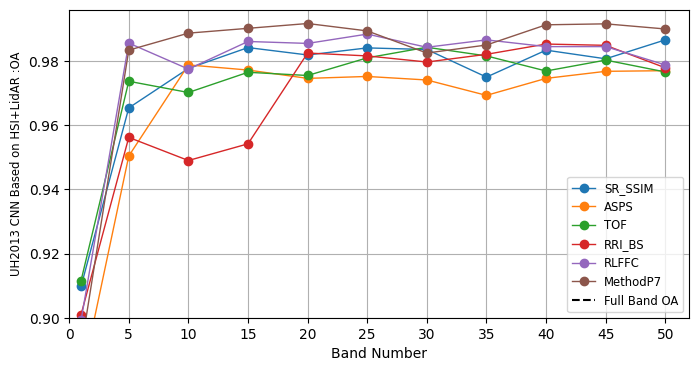

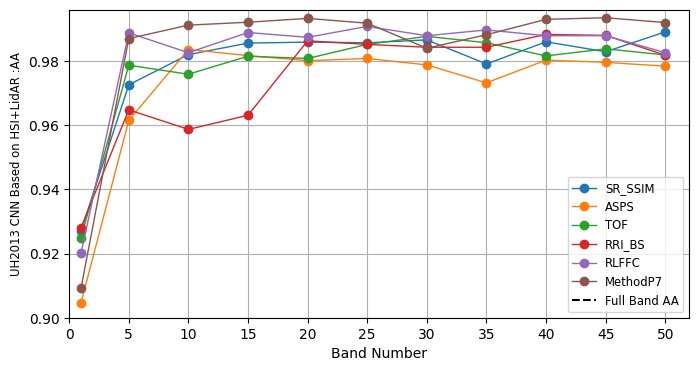

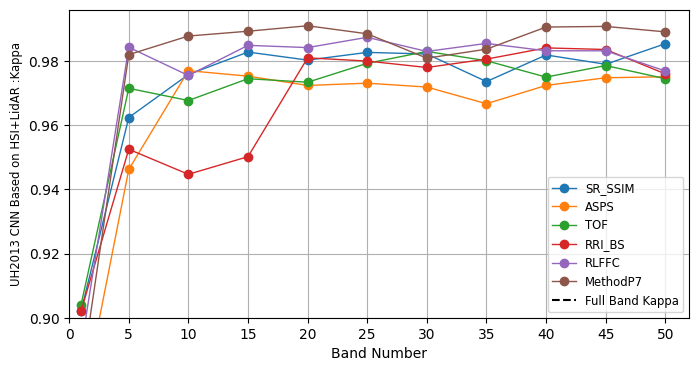

In [ ]:
# Test Result on Jan.26. 2024
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

# MUUFL SVM test data(Ablation study)# Remove 1
# Provided data for metrics and seed conditions
data = {
    "Band Number": [50, 50, 50, 45, 45,45, 40,40,40, 35, 35, 35, 30, 30,30,25, 25,25,20, 20,20,15,15,15, 10,10,10, 5,5,5,1,1,1],
    "Metrics": ['OA', 'AA', 'Kappa']*11,
    'SR_SSIM': [0.9866, 0.9891, 0.9854, 0.9807, 0.9829, 0.9790, 0.9834, 0.9860, 0.9819, 0.9750, 0.9791, 0.9736, 0.9836, 0.9866, 0.9822, 0.9841, 0.9857, 0.9827, 0.9819, 0.9859, 0.9803, 0.9842, 0.9856, 0.9828, 0.9777, 0.9820, 0.9758, 0.9654, 0.9726, 0.9624, 0.9098, 0.9271, 0.9021],
'ASPS': [0.9770, 0.9784, 0.9751, 0.9768, 0.9796, 0.9748, 0.9746, 0.9803, 0.9724, 0.9693, 0.9732, 0.9667, 0.9741, 0.9788, 0.9719, 0.9752, 0.9808, 0.9731, 0.9746, 0.9801, 0.9724, 0.9772, 0.9817, 0.9753, 0.9788, 0.9836, 0.9770, 0.9504, 0.9615, 0.9462, 0.8801, 0.9047, 0.8708],
'TOF': [0.9766, 0.9819, 0.9745, 0.9803, 0.9838, 0.9786, 0.9769, 0.9816, 0.9750, 0.9816, 0.9857, 0.9801, 0.9843, 0.9877, 0.9830, 0.9810, 0.9852, 0.9793, 0.9755, 0.9808, 0.9734, 0.9765, 0.9815, 0.9745, 0.9702, 0.9759, 0.9677, 0.9737, 0.9787, 0.9715, 0.9116, 0.9250, 0.9041],
'RRI_BS': [0.9779, 0.9818, 0.9760, 0.9849, 0.9880, 0.9836, 0.9853, 0.9883, 0.9841, 0.9821, 0.9843, 0.9806, 0.9797, 0.9843, 0.9780, 0.9816, 0.9852, 0.9800, 0.9825, 0.9863, 0.9810, 0.9542, 0.9631, 0.9502, 0.9490, 0.9587, 0.9447, 0.9562, 0.9648, 0.9525, 0.9010, 0.9281, 0.9021],
'RLFFC': [0.9788, 0.9826, 0.9769, 0.9845, 0.9879, 0.9832, 0.9845, 0.9879, 0.9832, 0.9866, 0.9897, 0.9855, 0.9843, 0.9879, 0.9830, 0.9884, 0.9908, 0.9874, 0.9855, 0.9874, 0.9842, 0.9861, 0.9889, 0.9849, 0.9775, 0.9826, 0.9755, 0.9856, 0.9888, 0.9843, 0.8992, 0.9202, 0.8907],
'MethodP7': [0.9900, 0.9920, 0.9891, 0.9916, 0.9935, 0.9908, 0.9913, 0.9930, 0.9906, 0.9850, 0.9882, 0.9837, 0.9825, 0.9840, 0.9809, 0.9894, 0.9918, 0.9885, 0.9917, 0.9933, 0.9910, 0.9902, 0.9921, 0.9893, 0.9887, 0.9912, 0.9878, 0.9834, 0.9870, 0.9820, 0.8902, 0.9093, 0.8810]
}

# Creating a DataFrame
df_mf_cnn = pd.DataFrame(data)

metrics = ['OA', 'AA', 'Kappa']
methods = ['SR_SSIM', 'ASPS',  'TOF', 'RRI_BS','RLFFC','MethodP7']

full_bands = {'OA': 0.8532, 'AA': 0.878, 'Kappa': 0.8392}

# Define the band_numbers variable
band_numbers = df_mf_cnn['Band Number'].unique()

# Iterate over metrics to create each plot
for metric in metrics:
    plt.figure(figsize=(8, 4))

    # Extract and plot data for each method
    for method in methods:
        values = df_mf_cnn[df_mf_cnn['Metrics'] == metric][method].values
        plt.plot(band_numbers, values, marker='o', label=method, linewidth=1.5 if method == 'Our method' else 1.0)

    # Add the straight line for the full band benchmark
    plt.axhline(full_bands[metric], color='black', linestyle='--', label=f'Full Band {metric}')

    plt.xlabel('Band Number')
    plt.ylabel(f'UH2013 CNN Based on HSI+LidAR :{metric}', fontsize='small')
    plt.legend(loc='lower right', fontsize='small')
    plt.grid(True)
    plt.ylim(0.9000, 0.9960)
    plt.xlim(0, 52)
    ax = plt.gca()
    ax.xaxis.set_major_locator(MultipleLocator(5))
    plt.show()